In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

from matplotlib import pyplot as plt
import category_encoders as ce
from textblob import TextBlob



In [7]:
raw_df = pd.read_csv("tmdb-movies.csv")


In [8]:
def read_prep_data(df):

    # Select Columns of Interest
    cols_of_interest = [
        "vote_average", "vote_count", "status", "release_date", 
        "revenue", "runtime", "budget", "overview", "popularity", 
        "genres", "production_companies", "production_countries", "spoken_languages", "keywords"
    ]

    df = df[cols_of_interest]
    df = df[df.vote_average > 0]

    # Extract release year and age of the movie
    df["release_year"] = pd.to_datetime(df.release_date).dt.year
    df["movie_age"] = 2024 - df["release_year"]
    df["overview_word_count"] = df["overview"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    df["overview_sentiment"] = df["overview"].apply(lambda x: TextBlob(x).sentiment.polarity if pd.notna(x) else 0)

    # Log transformation for skewed numerical features
    df["log_budget"] = np.log1p(df["budget"])
    df["log_revenue"] = np.log1p(df["revenue"])
    df["log_popularity"] = np.log1p(df["popularity"])

    # Replace missing values
    df.fillna(0, inplace=True)

    # Drop columns we no longer need
    df.drop(columns=["release_date", "release_year", "budget", "revenue", "popularity"], inplace=True)

    return df

In [9]:
df = read_prep_data(raw_df)

/Users/sethurama/Library/Caches/pypoetry/virtualenvs/mlzc-movie-pred-0bbqC9PW-py3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350076 entries, 0 to 1130860
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vote_average          350076 non-null  float64
 1   vote_count            350076 non-null  int64  
 2   status                350076 non-null  object 
 3   runtime               350076 non-null  int64  
 4   overview              350076 non-null  object 
 5   genres                350076 non-null  object 
 6   production_companies  350076 non-null  object 
 7   production_countries  350076 non-null  object 
 8   spoken_languages      350076 non-null  object 
 9   keywords              350076 non-null  object 
 10  movie_age             350076 non-null  float64
 11  overview_word_count   350076 non-null  int64  
 12  overview_sentiment    350076 non-null  float64
 13  log_budget            350076 non-null  float64
 14  log_revenue           350076 non-null  float64
 15  log_

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train['vote_average'].values
y_val = df_val['vote_average'].values
y_test = df_test['vote_average'].values
y_full_train = df_full_train['vote_average'].values

del df_train['vote_average']
del df_val['vote_average']
del df_test['vote_average']
del df_full_train['vote_average']

df_train.shape, df_val.shape, df_test.shape

((210045, 15), (70015, 15), (70016, 15))

In [12]:
# List of features for processing
numerical_features = ["runtime", "vote_count", "log_budget", "log_revenue", "log_popularity", "movie_age", "overview_word_count", "overview_sentiment"]
categorical_features_small = ["status"]
high_cardinality_features = ["genres", "production_companies", "production_countries", "spoken_languages", "keywords"]


# Target Encoding for High Cardinality Features
target_enc = ce.TargetEncoder(cols=high_cardinality_features)
df_train_encoded = target_enc.fit_transform(df_train, y_train)
df_test_encoded = target_enc.transform(df_test)

df_train = df_train_encoded.reset_index(drop=True)
df_test = df_test_encoded.reset_index(drop=True)



In [13]:
# Create Pipelines for Numerical and Categorical Features

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    # Fill missing values with mean
    ('scaler', StandardScaler())                    # Standardize numerical values
])

# Categorical Transformer for One-Hot Encoding (for low cardinality categorical features)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer to apply transformations to different features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features_small)
    ],
    remainder='drop'  # Drop any columns not specified
)



In [14]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

model.fit(df_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['runtime', 'vote_count',
                                                   'log_budget', 'log_revenue',
                                                   'log_popularity',
                                                   'movie_age',
                                                   'overview_word_count',
                                                   'overview_sentiment']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sta...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [15]:
test_predictions = model.predict(df_test)
print("Test Predictions: ", test_predictions[:5])

Test Predictions:  [5.3213153 6.8552866 6.2414894 5.961068  5.893515 ]


In [16]:
test_predictions[test_predictions < 3]

array([2.4284039, 2.6739519, 2.3335257, 2.8809135, 2.8402596, 2.832331 ],
      dtype=float32)

In [17]:
root_mean_squared_error(test_predictions, y_test)

np.float64(1.828848644444252)

In [18]:
# Check XGB train / val 

In [19]:
X_train_pp = preprocessor.fit_transform(df_train)
X_val_pp = preprocessor.transform(df_val)

dtrain = xgb.DMatrix(X_train_pp, label=y_train)
dval = xgb.DMatrix(X_val_pp, label=y_val)

In [20]:

xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 20,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
    'lambda': 1,      # L2 regularization 
    'alpha': 1,       # L1 regularization 
}

evals=[(dtrain, "train"), (dval, "val")]
evals_result={}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=150,
    early_stopping_rounds=10,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False
)


In [21]:
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['val']['rmse']
itrs = list(range(1, len(train_rmse) + 1))


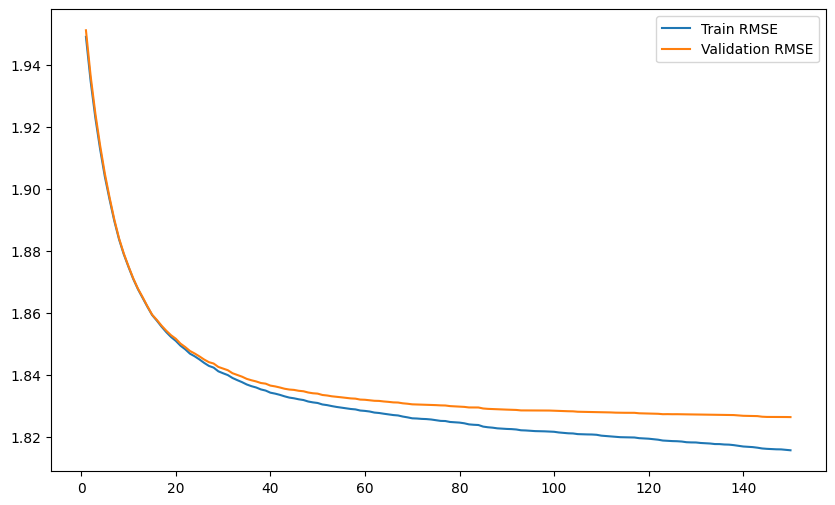

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(itrs, train_rmse, label='Train RMSE')
plt.plot(itrs, val_rmse, label='Validation RMSE')
plt.legend()


In [23]:
def model_train(eta=0.1, max_depth=5, min_child_weight=20):
    xgb_params = {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
    
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
    
        'nthread': 8,
    
        'seed': 1,
        'verbosity': 1,
        'lambda': 1,      # L2 regularization 
        'alpha': 1,       # L1 regularization 
    }

    evals=[(dtrain, "train"), (dval, "val")]
    evals_result={}
    
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=150,
        early_stopping_rounds=10,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False
    )
    train_rmse = evals_result['train']['rmse']
    val_rmse = evals_result['val']['rmse']
    itrs = list(range(1, len(train_rmse) + 1))

    return (itrs, train_rmse, val_rmse)


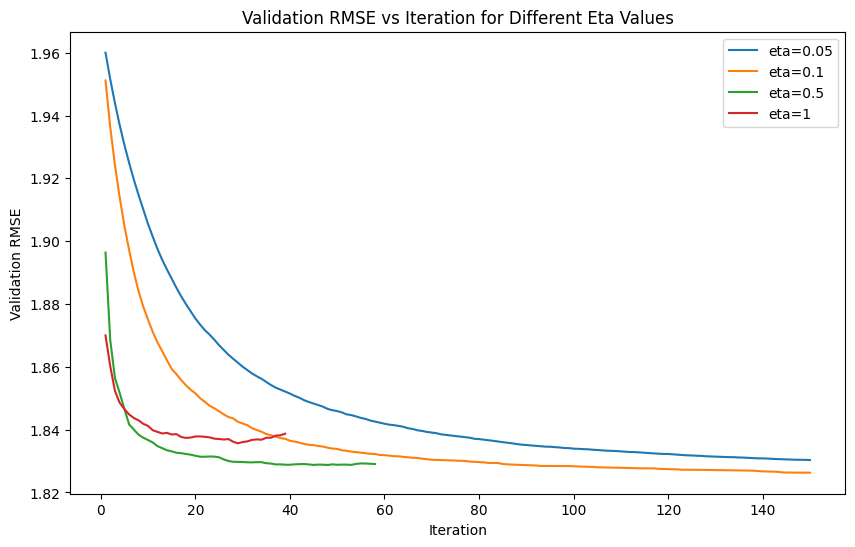

In [24]:
eta_scores = [0.05, 0.1, 0.5, 1]
plt.figure(figsize=(10, 6))

for eta in eta_scores:
    itrs, train_rmse, val_rmse = model_train(eta=eta)
    plt.plot(itrs, val_rmse, label=f"eta={eta}")

plt.xlabel('Iteration')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs Iteration for Different Eta Values')
plt.legend()
plt.show()

In [25]:
eta = 0.1

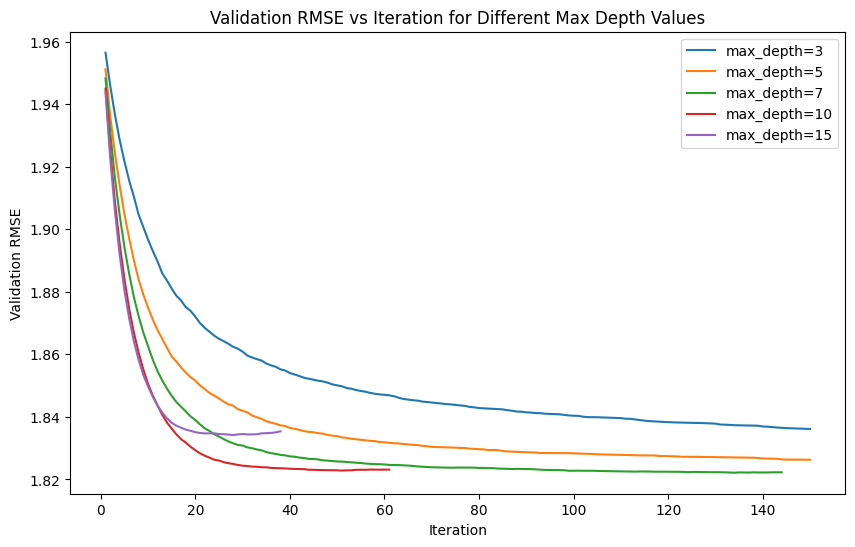

In [26]:
md_scores = [3, 5, 7, 10, 15]
plt.figure(figsize=(10, 6))

for md in md_scores:
    itrs, train_rmse, val_rmse = model_train(max_depth=md)
    plt.plot(itrs, val_rmse, label=f"max_depth={md}")

plt.xlabel('Iteration')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs Iteration for Different Max Depth Values')
plt.legend()
plt.show()

In [27]:
max_depth=7

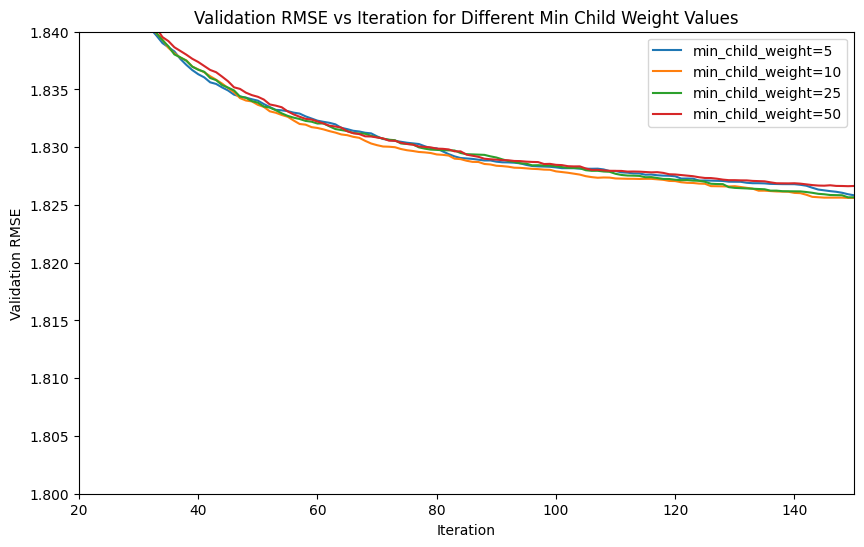

In [28]:
mcw_scores = [5, 10, 25, 50]
plt.figure(figsize=(10, 6))

for mcw in mcw_scores:
    itrs, train_rmse, val_rmse = model_train(min_child_weight=mcw)
    plt.plot(itrs, val_rmse, label=f"min_child_weight={mcw}")

plt.xlabel('Iteration')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs Iteration for Different Min Child Weight Values')

plt.xlim(20, 150)
plt.ylim(1.8, 1.84)

plt.legend()
plt.show()

In [29]:
min_child_weight = 10

In [30]:
preprocessor.get_feature_names_out()

array(['num__runtime', 'num__vote_count', 'num__log_budget',
       'num__log_revenue', 'num__log_popularity', 'num__movie_age',
       'num__overview_word_count', 'num__overview_sentiment',
       'cat__status_Canceled', 'cat__status_In Production',
       'cat__status_Planned', 'cat__status_Post Production',
       'cat__status_Released', 'cat__status_Rumored'], dtype=object)

In [31]:
# Final Model


In [32]:
X_full_train_pp = preprocessor.fit_transform(df_full_train)
X_test_pp = preprocessor.transform(df_test)

dfulltrain = xgb.DMatrix(X_full_train_pp, label=y_full_train)
dtest = xgb.DMatrix(X_test_pp, label=y_test)

In [33]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 7,
    'min_child_weight': 10,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
    'lambda': 1,      # L2 regularization 
    'alpha': 1,       # L1 regularization 
}

evals=[(dtrain, "train"), (dval, "val")]
evals_result={}

model = xgb.train(
    xgb_params,
    dfulltrain,
    num_boost_round=150,
    early_stopping_rounds=10,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False
)


In [34]:
test_pred = model.predict(dtest)
root_mean_squared_error(test_pred, y_test)

np.float64(1.8241877372072486)

In [35]:
len(test_pred[(test_pred > 2) & (test_pred < 4)])

121

In [36]:
# df['log_budget'] = pd.to_numeric(df['log_budget'], errors='coerce')
# df['log_budget'] = df['log_budget'].fillna(0)
df[df['log_budget'] <= 0]['log_budget'].sum()

np.float64(0.0)

In [37]:
df[df['log_revenue'] <= 0]['log_revenue'].sum()

np.float64(0.0)

In [38]:
df[df['log_popularity'] <= 0]['log_popularity'].sum()

np.float64(0.0)

In [39]:
df_full_train.iloc[33].to_dict()


{'vote_count': 1,
 'status': 'Released',
 'runtime': 94,
 'overview': "Based on the novel Winterkill, by William Judson, Cold River is the story of an Adirondack guide who takes his young daughter and step-son on a long camping trip in the fall of 1932. When winter strikes unexpectedly early (a natural phenomenon known as a 'winterkill' - so named because the animals are totally unprepared for a sudden, early winter, and many freeze or starve to death), a disastrous turn of events leaves the two children to find their own way home without food, or protection from the elements.",
 'genres': 'Adventure',
 'production_companies': 0,
 'production_countries': 'United States of America',
 'spoken_languages': 'English',
 'keywords': 'winter, camping',
 'movie_age': 42.0,
 'overview_word_count': 89,
 'overview_sentiment': 0.013636363636363629,
 'log_budget': 0.0,
 'log_revenue': 0.0,
 'log_popularity': 0.9162907318741551}

In [40]:
import json
raw_df.iloc[1].to_dict()

{'id': 157336,
 'title': 'Interstellar',
 'vote_average': 8.417,
 'vote_count': 32571,
 'status': 'Released',
 'release_date': '2014-11-05',
 'revenue': 701729206,
 'runtime': 169,
 'adult': False,
 'backdrop_path': '/pbrkL804c8yAv3zBZR4QPEafpAR.jpg',
 'budget': 165000000,
 'homepage': 'http://www.interstellarmovie.net/',
 'imdb_id': 'tt0816692',
 'original_language': 'en',
 'original_title': 'Interstellar',
 'overview': 'The adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.',
 'popularity': 140.241,
 'poster_path': '/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg',
 'tagline': 'Mankind was born on Earth. It was never meant to die here.',
 'genres': 'Adventure, Drama, Science Fiction',
 'production_companies': 'Legendary Pictures, Syncopy, Lynda Obst Productions',
 'production_countries': 'United Kingdom, United States of America',
 'spoken_languages': 'Engl

In [52]:
list(raw_df[raw_df.vote_average < 4].title)[:10]

['Dragonball Evolution',
 'Sharknado',
 'Epic Movie',
 'The Open House',
 'Disaster Movie',
 'Battlefield Earth',
 'The Human Centipede 3 (Final Sequence)',
 'Alone in the Dark',
 'Fuga da Reuma Park',
 'Rollerball']

In [43]:
import requests

# Select a movie from the dataset for prediction 
# Only the necessary columns will be considered. The y-value (vote_average) in the raw_df col would be removed 
# in the API call before the action prediction. 
movie = raw_df.iloc[23].to_dict()
for key, value in movie.items():
    if isinstance(value, float) and np.isnan(value):
        movie[key] = None

# Define host and endpoint
host = "0.0.0.0:9696"

# Send POST request for prediction
response = requests.post(
    url=f'http://{host}/rate',
    json=movie
)

# Output the response
print(response.json())

{'movie_title': 'Avengers: Age of Ultron', 'predicted_rating': 7.187842845916748}


In [53]:
def movie_rating_predictor(movie: dict):
    
    for key, value in movie.items():
        if isinstance(value, float) and np.isnan(value):
            movie[key] = None
            
    response = requests.post(
        url=f'http://{host}/rate',
        json=movie
    )
    print(response.json())

In [54]:
movie = raw_df[raw_df.title == 'Laserblast'].to_dict(orient="records")[0]
movie_rating_predictor(movie)


{'movie_title': 'Laserblast', 'predicted_rating': 5.95926570892334}


In [56]:
movie = raw_df[raw_df.title == 'Epic Movie'].to_dict(orient="records")[0]
movie_rating_predictor(movie)


{'movie_title': 'Epic Movie', 'predicted_rating': 5.813991069793701}


In [ ]:
movie = raw_df[raw_df.title == 'The Batman'].to_dict(orient="records")[0]
movie_rating_predictor(movie)